# xG model of EPL from season 2017 to 2023
This notebook aims to replicated the paper's [Explainable expected goal models for performance analysis in football analysics](https://ieeexplore.ieee.org/document/10032440) techniques. <br>
Here is the [github link](https://github.com/mcavs/Explainable_xG_model_paper) of the paper.

## Set up

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.model_selection import train_test_split

# import all functions from utils.py
from utils import *

In [2]:
# import data
current_dir = os.getcwd()

df = import_epl_data(2017, 2023, current_dir + '/Data/')
print(f"shape of data: {df.shape}")


shape of data: (57029, 26)


## Data preprocessing

In [3]:
# drop inapporiate columns
columns_to_drop = ['Unnamed: 0', 'league', 'minute', 'h_team', 'a_team', 'h_goals', 'a_goals',
                   'player', 'h_a', 'player_id', 
                   'match_id', 'home_team', 'away_team', 'home_goals', 'away_goals',
                   'date', 'player_assisted', 'xG']
df.drop(columns=columns_to_drop, inplace = True)
df.set_index('id', inplace=True) # set id as index
print(f"shape of data after dropping columns: {df.shape}")

shape of data after dropping columns: (57029, 7)


In [4]:
# create two new columns: distance and angle
L = 105.0 # length of pitch in meters
W = 68.0 # width of pitch in meters
a = 7.32 # radius of goal in meters
df['distance'] = np.sqrt( (L * (1 - df["X"]))**2 + (W * (0.5 - df["Y"]))**2 )
df['angle'] = abs(np.arctan((a * (L * (1 - df["X"]))) / ((L * (1 - df["X"]))**2 + (W * (0.5 - df["Y"]))**2 - (a/2)**2) * 180 / math.pi))

In [5]:
df["goal"] = np.where(df["result"] == "Goal", 1, 0) # create a new column goal as target variable
df.drop(columns=['result'], inplace=True) # drop result column

In [6]:
# one hot encoding
df_preprocessed = pd.get_dummies(df, columns=['situation', 'shotType', 'lastAction'])
print(f"shape of preprocessed data: {df_preprocessed.shape}")

shape of preprocessed data: (57029, 50)


In [9]:
# split data into train (2017 - 2022) and test (2022-2023)
df_train = df_preprocessed[df_preprocessed['season'] != '22-23'] # train data is from 17-18 to 21-22
df_test = df_preprocessed[df_preprocessed['season'] == '22-23'] # test data is from 22-23
X_train = df_train.drop(columns=['goal', 'season'])
y_train = df_train['goal']
X_test = df_test.drop(columns=['goal', 'season'])
y_test = df_test['goal']

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (47385, 48)
shape of X_test: (9644, 48)
shape of y_train: (47385,)
shape of y_test: (9644,)


## Modeling

In [14]:
# train a xgboost model
import xgboost as xgb

classifier_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
)
classifier_xgb.fit(X_train, y_train)
class_xgb = classifier_xgb.predict(X_test)

In [15]:
# Accuracy of test data
print(classifier_xgb.score(X_test, y_test))

0.9014931563666528


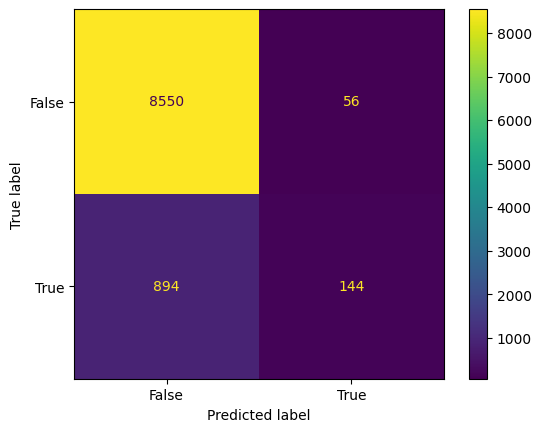

In [18]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, class_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

## Evaluation